# Konkurs | 6 edycja kursu "Praktyczne uczenie maszynowe" - Dlaczego tak ważna jest walidacja? 


### Cel:
Prognozowanie wartości zwrotu dla danego zamówienia. 

### Na czym polega konkurs?
Jest sklep online, który sprzedaje różne produkty dla ludzi z różnych krajów. Jedno zamówienie (faktura) może zawierać więcej niż jeden produkt. Trend, który jest dość popularny w szczególności w krajach zachodnich, to możliwość zwrotów i klienci chętnie z tego korzystają. Zwroty generują koszty i warto umieć przewidzieć to i jakoś z tym podziałać (pomijając skrajne przypadki takie jak "nie sprzedawać" klientowi X, bo to pewnie jest zakazane prawem). Natomiast pewnie dałoby się coś zrobić, jeśli wiedzielibyśmy, które zamówienia mogą być z dużym prawdopodobieństwem zwrócone.

**To zadanie można podzielić na 2 części**: z jednej strony jest to klasyfikacja, ponieważ ostatecznie trzeba stwierdzić, **czy ten produkt będzie zwrócony czy nie**. Z drugiej strony (i to jest docelowe zadanie) przez to, że zamówienie może zawierać więcej niż jeden produkt, to **ostatecznie chcemy obliczyć sumaryczny koszt zwrotów**. Możesz założyć, że jeśli w danym złożonym i opłaconym zamówieniu jest zwrot nawet jednego produktu, to zwracana jest całość zamówienia (czyli wszystkie produkty zawarte w tym zamówieniu). **Suma cen tych produktów daje całkowitą wartość zwrotu, właśnie to będziemy przewidydwać**.

### Metryką sukcesu
będzie **mean squared error**.

### Dane 
W danych jest **1 067 371** wierszy, które zostały podzielone prawie na równe części:
- `train_online_retail` (520 142 wierszy)
- `test_online_retail` (547 229 wierszy)

### Walidacja 
- lokalna na zbiorze testowym 
- na 30% danych testowych czyli "Public Leader Board" na Kaggle 
- na 70% danych testowych czyli "Private Leader Board" 
- na całym zbiorze testowym 

### Wczytanie potrzebnych pakietów

In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GroupKFold
from sklearn import utils
from scikitplot.estimators import plot_learning_curve, plot_feature_importances
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from collections import defaultdict 
import eli5
from eli5.sklearn import PermutationImportance
import gc

np.random.seed(0)

Using TensorFlow backend.


### Dane

In [2]:
test =  pd.read_hdf('../input/test_online_retail.h5')
train = pd.read_hdf('../input/train_online_retail.h5')

Opis:
- `invoice` - nr. faktury
- `stock_code` - produkt ID
- `description` - opis produktu
- `quantity` - liczba kupionych tych samych produktów w ramach jednej transakcji
- `invoice_date` - data wystawienie faktury
- `price_unit` - cena jednostkowa produktu za sztukę w funtach
- `price_total` - cena razem `price_unit * quantity` 
- `customer_id` - klient ID
- `country` - nazwa kraju, z którego klient kupował
- `is_canceled` - czy faktura była anulowana
- `is_test` - czy to zbiór testowy

In [3]:
train.head()

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
12,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,False
13,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,False
14,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,False
15,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,False
16,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,False


In [3]:
train['total_return'] = train['is_canceled'] * train['price_total']

In [4]:
orders = train.groupby('invoice')['is_canceled', 'price_total'].sum()
orders['is_canceled'] = orders['is_canceled'] > 0
orders['total_return'] = orders ['is_canceled'] * orders ['price_total']
orders = orders.reset_index()
orders.head()

,invoice,is_canceled,price_total,total_return
0,2,False,630.330017,0.0
1,3,False,310.750000,0.0
2,4,False,2286.239990,0.0
3,5,False,426.299988,0.0
4,8,False,382.369995,0.0


Do danych możemy podejć na dwa sposoby po pierwsze możemy pronozować zwrot pojedyńczego produktu i po dokonaniu obliczeń, pogrupować całkowity zwrot do numeru faktury. Lub najpier pogrupować do dane do pojedyńczej faktury a następnie pronozować czy dane faktura zostanie zwrócona czy też nie. Każdy z tych sposobów ma swoje wady i zalety. Pierwszy jest tudniejszy w walidacji - w końcowej fazie mamy otrzymać numer faktury i sume zwrotów wiec musimy przejśc z prognozą do faktur by móc policzyc MSE oraz musimy pamiętać by wiersze zbiorach testowym i walidacynym pogrupować po fakturze tak by nie było przypadku ze produkty z jednego zamówienia trafiają do zbiory treningowego i testowego. Drugie podejście jest prostrze w walidacji, jednak trudniej przekazać informację o produktach.

W tym notebooku skupię się na pierwszym podejściu poniważ ma ciekawsze podjeście do walidacji, oraz ono osiągneło u mnie ostatecznie lepsze wyniki 

### Dummy model: 

In [66]:
#funkcja na wyrost przyda nam się to poźniej 
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['is_canceled', 'is_test', 'is_canceled_pred', 'total_return_proc', 'big_invoice','total_return', 'total_return_pred','y_pred','total_return_pred1','total_return_pred2' ]
    return [x for x in feats if x not in black_list] 

In [6]:
def run_model ( train,test, model_cls, model_params):
    feats = get_feats(train)  # w tym przypadku wszystko jedno jaka kolumna
    X = train[feats].values
    y = train['total_return'].values
    model = model_cls(**model_params)
    model.fit(X, y)
    train['y_pred'] = model.predict(X)
    
    df = train.groupby('invoice').sum()
    mse_lokalnie = mse(df.y_pred.values, df.total_return.values)
    
    print('mse lokalne:')
    return mse_lokalnie 

In [7]:
dummy1 = run_model(train,test,DummyRegressor,{'strategy':'mean'})
dummy1

mse lokalne:


1499568.6

In [8]:
#przepisane z tablicy na Kagglu 
kaggle_private= 108089.48672
kaggle_public = 233990.04073

def mse_kaggle_total(kaggle_private,kaggle_public): 
    return (kaggle_private*70 + kaggle_public*30 ) / 100

Zapiszmy ten wynik przyda się nam to później:

In [9]:
wyniki = [['DummyRegressor',dummy1, kaggle_private ,kaggle_public, mse_kaggle_total(kaggle_private,kaggle_public)]]

Sprawdźmy nasz zbiór testowy pod kontem duplikatów lub pustych wartości: 
    

In [13]:
train[train.duplicated() == True].sample ( 5 )

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test,total_return,y_pred
149,27745,4434,ALARM CLOCK BAKELIKE GREEN,4,2010-12-01 09:45:00,3.750000,15.00,880,United Kingdom,False,False,0.0,1.816563
17637,28538,1180,HOME SWEET HOME MUG,1,2010-12-08 12:35:00,1.250000,1.25,4377,United Kingdom,False,False,0.0,1.816563
228117,13226,3832,HANGING METAL HEART LANTERN,6,2010-06-08 13:22:00,1.650391,9.90,666,United Kingdom,False,False,0.0,1.816563
482268,51324,4363,HAND WARMER OWL DESIGN,1,2011-11-20 11:09:00,2.099609,2.10,4267,United Kingdom,False,False,0.0,1.816563
781,27784,162,BLACK SWEETHEART BRACELET,2,2010-12-01 12:23:00,4.250000,8.50,3137,United Kingdom,False,False,0.0,1.816563


Jest tego sporo bo az 15691 wierszy - ja uznałam to za błąd w zbiorze danych i postanowiłam je usunąć 

In [11]:
train = train.drop_duplicates() #usuniecie duplikatów 

In [10]:
train = train.fillna(-1)

Obserwację odstające: 

In [111]:
train.describe()

,invoice,stock_code,quantity,price_unit,price_total,customer_id,total_return,y_pred
count,504451.000000,504451.000000,504451.000000,504451.000000,504451.000000,504451.000000,504451.000000,504451.000000
mean,28132.371148,2094.309877,12.336435,NaN,21.941849,1498.887755,1.804682,1.813338
std,15785.569675,1764.789184,207.850433,NaN,386.183929,1659.756246,277.436707,0.003233
min,2.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,1.816563
25%,14646.000000,437.000000,1.000000,1.250000,3.900000,49.000000,0.000000,1.816563
50%,28582.000000,1443.000000,4.000000,2.099609,10.040000,820.000000,0.000000,1.816563
75%,42199.000000,4009.000000,12.000000,4.128906,17.700001,2553.000000,0.000000,1.816563
max,53627.000000,5304.000000,80995.000000,53600.000000,168469.593750,5940.000000,168469.593750,1.816563


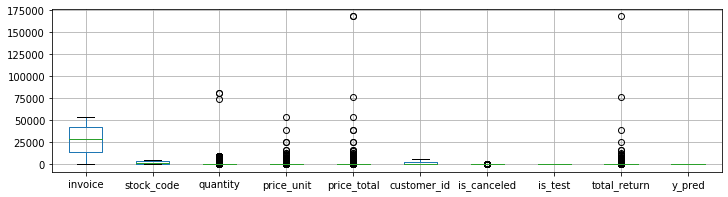

In [14]:
plt.figure(figsize=[12,3])
train.boxplot()

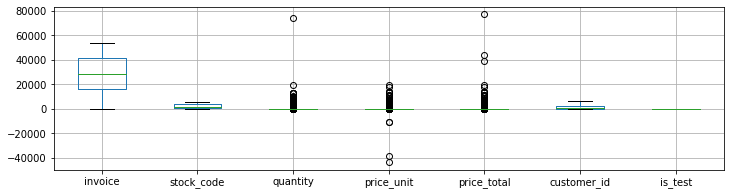

In [114]:
plt.figure(figsize=[12,3])
test.boxplot()

In [12]:
train = train[train['price_total'] != 168469.593750]

In [13]:
train = train.reset_index(drop = True)

Sprawdźmy jak zmini się wartość dummy modelu: 

In [14]:
dummy2 = run_model(train,test,DummyRegressor,{'strategy':'mean'})
dummy2 

mse lokalne:


407759.56

In [15]:
#przepisane z tablicy na Kagglu 
kaggle_private= 233898.07078
kaggle_public = 107984.05892
wyniki.append(['DummyRegressor_clean_train',dummy2, kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

PS przez chwile to rozwiązanie dawało mi 6 miejsce dlatego je tutaj zostawiam :) 

Chcąc walidować kolejne rozwiązania musimy zmodyfikowac nasze podjejście do walidacji dlatego przyjrzyjmy się jak wygląda rozkład zwracalności pojedyńczych produktów oraz całych faktur: 

In [16]:
def dist(df):
    print('train')
    print( df.is_canceled.value_counts(normalize=True).values * 100)
    
    df_agg = df.groupby('invoice').sum()
    df_agg['is_canceled'] = (df_agg['is_canceled'] > 0).astype(np.int)

    print('orders')
    print(df_agg['is_canceled'].value_counts(normalize=True).values * 100)

dist(train)

train
[98.06640513  1.93359487]
orders
[84.54050425 15.45949575]


W zbiorze testowym dla produktów mam 1.91% zwraconych produktów, natomiast gdy pogrupujemy dane do faktur mamy już 15% zwrotów. Należy pamiętać że wystarczy jeden produkt by faktura została zwrócona. Dlatego podzielny zbiór walidacyjny tak by nie rozdzielać faktur oraz zachować rozkład: 

In [17]:
X = train[['invoice', 'is_canceled']].values
y = train['is_canceled'].values
groups = train['invoice'].values

X_shuffled, y_shuffled, groups_shuffled = utils.shuffle(X, y, groups)

group_kfold = GroupKFold(n_splits=10)

for train_idx, test_idx in group_kfold.split(X_shuffled, y_shuffled, groups_shuffled):    
    sel_df = train[ train.invoice.isin( groups_shuffled[test_idx]) ]
    dist(sel_df)

train
[98.1504609  1.8495391]
orders
[85.22939202 14.77060798]
train
[97.96411934  2.03588066]
orders
[85.08019396 14.91980604]
train
[97.97403112  2.02596888]
orders
[83.9612085 16.0387915]
train
[98.02755476  1.97244524]
orders
[83.84930996 16.15069004]
train
[98.0810784  1.9189216]
orders
[84.48340172 15.51659828]
train
[98.10090197  1.89909803]
orders
[84.40880269 15.59119731]
train
[98.17424918  1.82575082]
orders
[84.74449832 15.25550168]
train
[97.84517792  2.15482208]
orders
[84.34004474 15.65995526]
train
[97.96015462  2.03984538]
orders
[83.85533184 16.14466816]
train
[98.38632939  1.61367061]
orders
[85.45318911 14.54681089]


In [18]:
class CustomCV:
    def __init__(self, groups, index, shuffle=True, n_splits=3, random_state=0):
        self.n_splits = n_splits
        self.groups = groups
        self.shuffle = shuffle
        self.index = index
        self.random_state = random_state

    def split(self, X, y, groups=None):
        if self.shuffle:
            X, y, self.groups, self.index = utils.shuffle(X, y, self.groups, self.index, random_state=self.random_state)

        group_kfold = GroupKFold(n_splits=self.n_splits)

        for train_idx, test_idx in group_kfold.split(X, y, self.groups):    
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test   = X[test_idx], y[test_idx]

            yield train_idx, test_idx 

    def get_index(self):
        return self.index

In [19]:
def group_and_calc_mse(train):
    train['total_return_pred1'] = (train['price_total'] * train['is_canceled_pred']).astype(np.int)
    train_agg = train.groupby('invoice')[ ['price_total', 'is_canceled_pred', 'is_canceled','total_return_pred1'] ].sum()

    train_agg['is_canceled'] = train_agg['is_canceled'] > 0
    train_agg['is_canceled_pred'] = train_agg['is_canceled_pred'] > 0

    train_agg['total_return'] = train_agg['price_total'] * train_agg['is_canceled']
    train_agg['total_return_pred2'] = train_agg['price_total'] * train_agg['is_canceled_pred']

    return (mse( train_agg['total_return'].values,  train_agg['total_return_pred2'].values) , 
            mse( train_agg['total_return'].values,  train_agg['total_return_pred1'].values))

def update_test_fold(y_pred, df, index_map, test_idx, pred_feat='is_canceled_pred'):
    sel_index = df.index.isin( index_map[test_idx] )
    df.loc[ sel_index, [pred_feat]] = y_pred
    
def run_cv(train, model_cls, model_params, n_splits=5, shuffle_rows=True, target='is_canceled', is_plot_learning_curve=True, return_mse = False, is_plot_feature_importances=True):
    train.fillna(-1, inplace=True)
    
    feats = get_feats(train)
    print(feats)
    
    X = train[feats].values
    y = train[target].values
    
    pred_feature = '{}_pred'.format(target)
    train[pred_feature] = np.nan
    
    cv = CustomCV(train['invoice'], train.index)
    
    for train_idx, test_idx in cv.split(X, y):    
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test   = X[test_idx], y[test_idx]
        model = model_cls(**model_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        update_test_fold(y_pred, train, cv.get_index(), test_idx)
    
    print('mse: ', group_and_calc_mse(train))
               
    if is_plot_learning_curve:
        title = 'Learning curve: {} {}'.format(model_cls.__name__, model_params)
        cv = CustomCV(train['invoice'], train.index)
        plot_learning_curve(model_cls(**model_params), X, y, title=title, figsize=(12, 3), random_state=0, cv=cv, scoring='f1')
    
    if return_mse:
        return group_and_calc_mse(train) 
    
    if is_plot_feature_importances:
        model = model_cls(**model_params)
        model.fit(X, y)
        perm = PermutationImportance(model, random_state=0).fit(X, y)
        return eli5.show_weights(perm, feature_names=feats) 

In [20]:
def make_submission(train, test, model_cls, model_params, target='is_canceled'):
    file_output1 = '../output/'+str(model_cls)+'pred_smaller''.csv'
    file_output2 = '../output/'+str(model_cls)+'pred_biger''.csv'
    
    feats = get_feats(train)
    X = train[feats].values
    y = train[target].values
    X_test_total = test[feats].values
    pred_feature = '{}_pred'.format(target)
    test[pred_feature] = np.nan
    model = model_cls(**model_params)
    model.fit(X, y)
    test[pred_feature] = model.predict(X_test_total)

    test['total_return_pred1'] = test[pred_feature].astype(np.int) * test['price_total']
    test_agg = test.groupby('invoice')[ ['price_total', 'is_canceled_pred','total_return_pred1'] ].sum()
    
    test_agg['is_canceled_pred'] = test_agg['is_canceled_pred'] > 0
    test_agg['total_return_pred2'] = test_agg['price_total'] * test_agg['is_canceled_pred']
    
    test_agg = test_agg.reset_index()
    
    test_agg = test_agg.rename(columns={'total_return_pred1': 'total_return'})
    test_agg[ ['invoice', 'total_return'] ].to_csv(file_output1, index=False)
    test_agg = test_agg.rename(columns={'total_return': 'total_return_pred1','total_return_pred2': 'total_return' })
    test_agg[ ['invoice', 'total_return'] ].to_csv(file_output2, index=False)
    
    print('ok!')

Mamy już walidację więc sprawdźmy pozostałe modele

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  (581184.94, 404442.5559680595)


Weight,Feature
0.0218 ± 0.0003,price_unit
0.0199 ± 0.0003,price_total
0.0030 ± 0.0001,customer_id
0.0025 ± 0.0002,quantity
0.0022 ± 0.0001,stock_code
0.0009 ± 0.0000,invoice


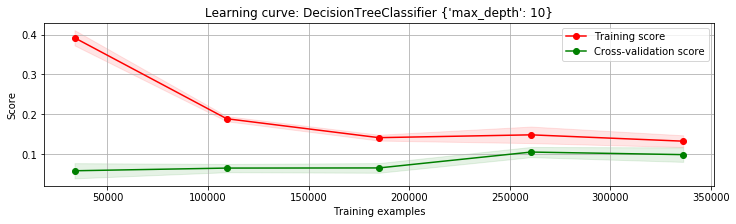

In [24]:
run_cv(train, DecisionTreeClassifier, {'max_depth': 10})

Przygladając się funkcji group_and_calc_mse możemy liczyć na dwa sposoby podejść do liczenia całkowitego zwrotu z faktury, możemy liczyć koszt tylko zwaracengo produktu lub całości. W tym przypadku bardziej opłaca nam się w sesnie MSE obliżyć koszt zwrotu do tylko jednego produktu. Zapiszmy wyniki: 

In [21]:
model_cls = DecisionTreeClassifier
model_params = {'max_depth': 10}
tree = run_cv(train, model_cls, model_params, return_mse = True,is_plot_learning_curve=False, is_plot_feature_importances=False)
make_submission(train, test, model_cls, model_params)

#przepisane z tablicy na Kagglu 
kaggle_private= 375955.94700
kaggle_public = 183956.84479
wyniki.append([str(model_cls) + "1",tree[0] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

#przepisane z tablicy na Kagglu 
kaggle_private= 410205.49473
kaggle_public = 283436.75369
wyniki.append([str(model_cls) + "2",tree[1] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])


['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  (581184.94, 404442.5559680595)
ok!


['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  (431661.5, 404398.4676725098)
ok!


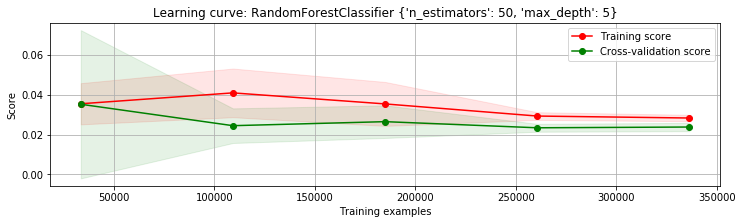

In [22]:
model_cls = RandomForestClassifier
model_params = {'n_estimators':50, 'max_depth':5}
forest = run_cv(train, model_cls, model_params, return_mse = True)
make_submission(train, test, model_cls, model_params)

#przepisane z tablicy na Kagglu 
kaggle_private= 54352.10835
kaggle_public = 114778.80839
wyniki.append([str(model_cls) + "1",forest[0] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

#przepisane z tablicy na Kagglu 
kaggle_private= 54322.40222
kaggle_public = 114778.80837
wyniki.append([str(model_cls) + "2",forest[1] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  (528766.5, 404557.35908468324)
ok!


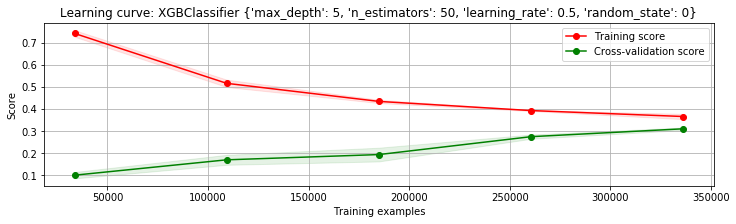

In [23]:
model_cls = xgb.XGBClassifier
model_params = {'max_depth': 5, 'n_estimators': 50, 'learning_rate': 0.5, 'random_state': 0}
xgb_ = run_cv(train, model_cls, model_params, return_mse = True)
make_submission(train, test, model_cls, model_params)

#przepisane z tablicy na Kagglu 
kaggle_private= 91135.04627
kaggle_public = 113179.76990
wyniki.append([str(model_cls) + "1",xgb_[0] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

#przepisane z tablicy na Kagglu 
kaggle_private= 64437.63815
kaggle_public = 84234.42992
wyniki.append([str(model_cls) + "2",xgb_[1] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

In [24]:
def make_df_and_plot(wyniki): 
    df = pd.DataFrame(data=wyniki,columns=['nazwa', 'mse_lokalnie', 'mse_kaggle_private','mse_kaggle_public','mse_kaggle_total'])
    df.plot.bar(x='nazwa' , figsize=(12,3),legend=True )

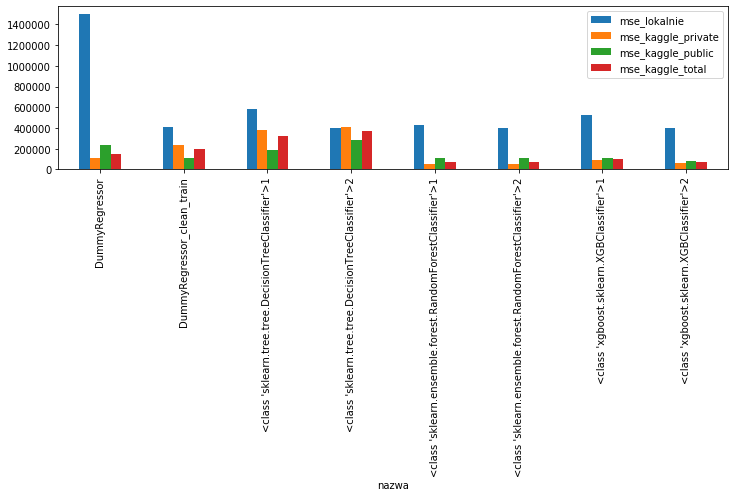

In [25]:
make_df_and_plot(wyniki)

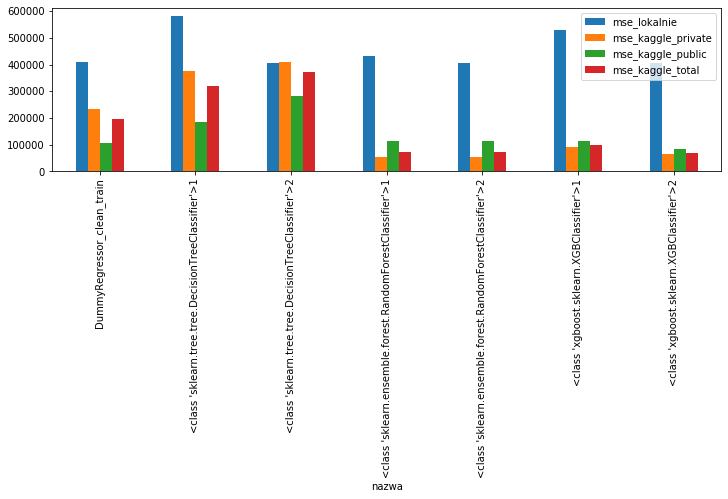

In [26]:
make_df_and_plot(wyniki[1:])

Ok więc mamy 3 modele, sama zmiana modelu nic nam nie dała dlatego należy przejść do tworzenia nowych cech: 

### Feature engineering

In [28]:
def group_to_dict(group_key, agg_func=np.sum):
    train = df_all[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1] 
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

In [29]:
df_all = pd.concat([train, test], sort=False)

#release memory
del train, test
gc.collect()

15730

In [30]:
#feature engineering
df_all['cnt_customer_cancel'] = df_all['customer_id'].map(group_to_dict('customer_id'))
df_all['cnt_customer_orders'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.size))
df_all['cnt_product_cancel'] = df_all['stock_code'].map(group_to_dict('stock_code'))
df_all['cnt_product_orders'] = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.size))

In [31]:
# prepare to train
train = df_all[ ~df_all['is_canceled'].isnull() ].copy()
test = df_all[ df_all['is_canceled'].isnull() ].copy()

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id', 'cnt_customer_orders', 'cnt_product_orders']
mse:  (529622.75, 404658.9002017018)
ok!


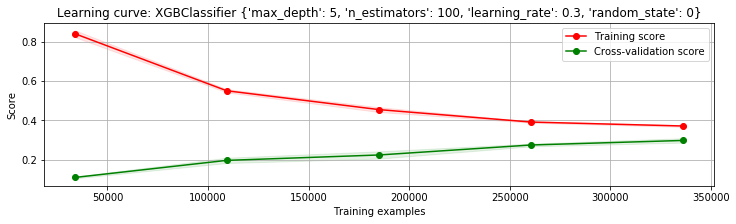

In [32]:
model_cls = xgb.XGBClassifier
model_params = {'max_depth': 5, 'n_estimators': 100, 'learning_rate': 0.3, 'random_state': 0}
xgb_ = run_cv(train, model_cls, model_params, return_mse = True)
make_submission(train, test, model_cls, model_params)

In [33]:
#przepisane z tablicy na Kagglu 
kaggle_private= 46135.18193
kaggle_public = 73713.97745
wyniki.append([str(model_cls) + "1",xgb_[0] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

#przepisane z tablicy na Kagglu 
kaggle_private= 52757.71606
kaggle_public = 76145.98521
wyniki.append([str(model_cls) + "2",xgb_[1] ,kaggle_private , kaggle_public,mse_kaggle_total(kaggle_private,kaggle_public)])

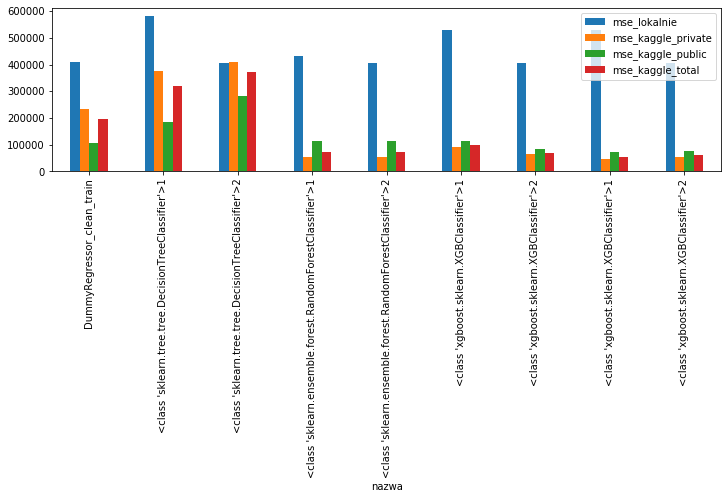

In [75]:
make_df_and_plot(wyniki[1:])

Lokalny wynik nie wskazuje jakbyśmy doszli do najlepszego rozwiązania na kagglu. To co możemy zrobić to, powtórzyć sztuczkę z usunięciem odstającej obserwacji. Czyli podzielić nasz zbiór na 2 części małych i dużych zamówień. 

In [35]:
train['total_return_proc'] = train['total_return'] * 100 / train['total_return'].sum()

In [71]:
train.sort_values(by='total_return_proc', ascending=False).head(20)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,...,total_return,y_pred,is_canceled_pred,total_return_pred1,cnt_customer_cancel,cnt_customer_orders,cnt_product_cancel,cnt_product_orders,total_return_proc,big_invoice
272422,30479,4647,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:17:00,1.040039,77183.601562,836,United Kingdom,True,...,77183.601562,1.470746,False,0,2,32.000000,4,132.0,10.403274,True
350594,39260,1232,Manual,1,2011-06-10 15:31:00,38976.000000,38970.000000,5040,United Kingdom,True,...,38970.000000,1.470746,False,0,1,2.000000,257,679.0,5.252613,True
120439,14000,1232,Manual,1,2010-06-17 16:52:00,25104.000000,25111.089844,2959,United Kingdom,True,...,25111.089844,1.470746,False,0,True,1.000000,257,679.0,3.384625,True
263664,29814,4574,AMAZON FEE,1,2011-01-05 09:55:00,16896.000000,16888.019531,-1,United Kingdom,True,...,16888.019531,1.470746,False,0,1.93891,80.985855,19,20.0,2.276270,True
263665,29815,4574,AMAZON FEE,1,2011-01-05 09:57:00,16448.000000,16453.710938,-1,United Kingdom,True,...,16453.710938,1.470746,False,0,1.93891,80.985855,19,20.0,2.217731,True
251474,28467,4574,AMAZON FEE,1,2010-12-07 15:34:00,13472.000000,13474.790039,-1,United Kingdom,True,...,13474.790039,1.470746,False,0,1.93891,80.985855,19,20.0,1.816214,True
496480,53030,4574,AMAZON FEE,1,2011-12-05 11:35:00,11584.000000,11586.500000,-1,United Kingdom,True,...,11586.500000,1.470746,False,0,1.93891,80.985855,19,20.0,1.561699,True
68126,7611,1232,Manual,1,2010-03-23 15:24:00,10952.000000,10953.500000,2100,United Kingdom,True,...,10953.500000,1.470746,False,0,2,2.000000,257,679.0,1.476379,True
68125,7609,1232,Manual,1,2010-03-23 15:20:00,10952.000000,10953.500000,2100,United Kingdom,True,...,10953.500000,1.470746,False,0,2,2.000000,257,679.0,1.476379,True
182549,21421,1232,Manual,1,2010-10-05 11:47:00,10472.000000,10468.799805,580,United Kingdom,True,...,10468.799805,1.470746,False,0,4,24.000000,257,679.0,1.411048,True


Mamy dwa wnioski spróbujmy wyizolować pierwsze 14 faktur ktróre stanowią wiecej niź 1% zamówień. Oraz możemy przydlągnąć sie opisom "Manual" oraz "AMAZON FEE"

In [38]:
lista = train[train['total_return_proc'] > 1 ].invoice.values
train['big_invoice']=  train.invoice.map(lambda x: True if x in lista else False )

In [60]:
train_small = train[train['big_invoice'] == False ].copy()

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id', 'cnt_customer_orders', 'cnt_product_orders']
mse:  (244347.34, 43592.26769200957)


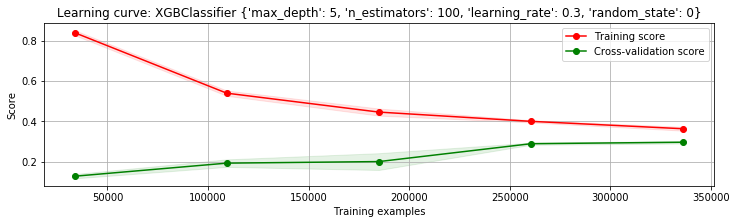

In [64]:
model_cls = xgb.XGBClassifier
model_params = {'max_depth': 5, 'n_estimators': 100, 'learning_rate': 0.3, 'random_state': 0}
xgb_ = run_cv(train_small, model_cls, model_params, return_mse = True)
wyniki[8].append(xgb_[0])
wyniki[9].append(xgb_[1])

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  (226158.38, 44155.275639788044)


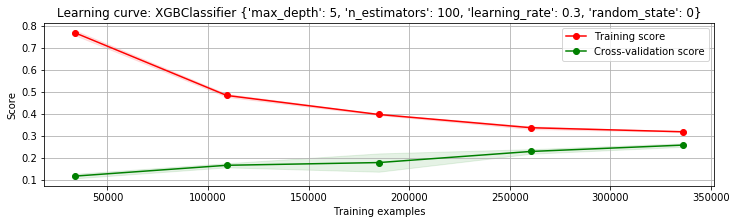

In [67]:
model_cls = xgb.XGBClassifier
model_params = {'max_depth': 5, 'n_estimators': 100, 'learning_rate': 0.3, 'random_state': 0}
xgb_ = run_cv(train_small, model_cls, model_params, return_mse = True)
wyniki[6].append(xgb_[0])
wyniki[7].append(xgb_[1])

In [81]:
model_cls = RandomForestClassifier
model_params = {'n_estimators':50, 'max_depth':5}
forest = run_cv(train_small, model_cls, model_params, return_mse = True, is_plot_learning_curve=False)
wyniki[4].append(forest[0])
wyniki[5].append(forest[1])

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  (55371.14, 45363.776742777736)


In [83]:
model_cls = DecisionTreeClassifier
model_params = {'max_depth': 10}
tree = run_cv(train_small, model_cls, model_params, return_mse = True,is_plot_learning_curve=False, is_plot_feature_importances=False)
wyniki[2].append(tree[0])
wyniki[3].append(tree[1])

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  (184609.47, 45405.34411975576)


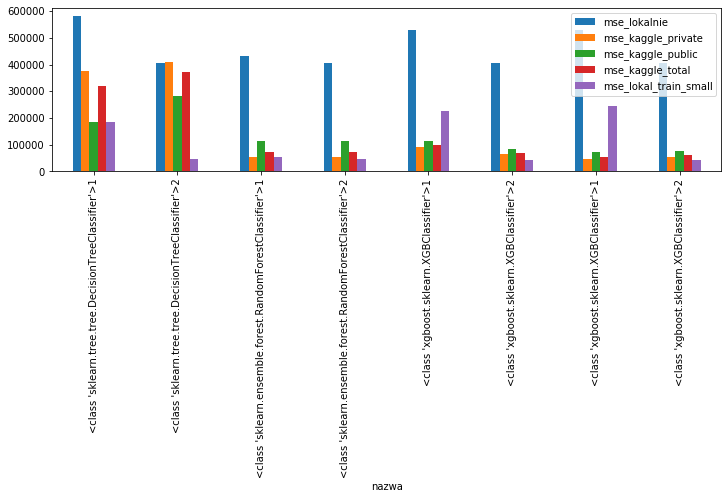

In [100]:
df = pd.DataFrame(data=wyniki[2:],columns=['nazwa', 'mse_lokalnie', 'mse_kaggle_private','mse_kaggle_public','mse_kaggle_total','mse_lokal_train_small'])
df.plot.bar(x='nazwa' , figsize=(12,3),legend=True)

Dzięki tak zredukowanemu zbiorowi nasze lokalane MSE odpowiada temu uzykanemu na Kaggle.Oczywiście to tego MSE należy dodać jeszcze MSE wygenrowane na pozostałym zbiorze train.invoice_big. Następnie możemy ekseprymentować dalej dokładając nowe cechy oraz trenować osobne modele dla drogich i tanich zamówień. 

In [76]:
df_all = pd.concat([train, test], sort=False)

#release memory
del train, test
gc.collect()

22069

In [ ]:
df_all['cnt_customer_cancel'] = df_all['customer_id'].map(group_to_dict('customer_id'))
df_all['cnt_customer_orders'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.size))
df_all['cnt_product_cancel'] = df_all['stock_code'].map(group_to_dict('stock_code'))
df_all['cnt_product_orders'] = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.size))

df_all['cnt_customer_product_cancel'] = df_all['cnt_customer_product_cancel'].astype(float)
df_all['cnt_product_cancel'] = df_all['cnt_product_cancel'].astype(float)

df_all['product_rate'] = df_all['cnt_product_cancel']*100/df_all['cnt_product_orders'] 
df_all['customer_rate'] = df_all['cnt_customer_product_cancel']*100 / df_all['cnt_customer_product_orders'] 
df_all['year'] = df_all.invoice_date.dt.year
df_all['month'] = df_all.invoice_date.dt.month
df_all['day'] = df_all.invoice_date.dt.day 
df_all['hour'] = df_all.invoice_date.dt.hour
df_all['day_of_week'] = df_all['invoice_date'].dt.weekday
df_all['woorking_day'] = df_all.day_of_week.map(lambda x: 0 if x >4 else 1 )
df_all['country_cat'] = pd.factorize(df_all['country'] )[0]
df_all['description'] = df_all['description'].astype(str)

df_all['customer_rate'] = df_all['customer_rate'].astype(float)
df_all['product_rate'] = df_all['product_rate'].astype(float)

In [51]:
train[train['description']== 'Manual'].groupby('is_canceled').size()

is_canceled
False    422
True     257
dtype: int64

In [52]:
train[train['description']== 'AMAZON FEE'].groupby('is_canceled').size()

is_canceled
False     1
True     19
dtype: int64

In [ ]:
df_all['Amazon_of_manual'] == df_all.description.map(lambda x: True if x in ['AMAZON FEE','Manual'] else False)